In [1]:
from CoolProp.CoolProp import PropsSI
import numpy as np
import matplotlib.pyplot as plt
# use the letters:
# ... T for (T)emperature
# ... P for (P)ressure
# ... D for (D)ensity
# ... Q for vapor quality x
# ... C for specific heat

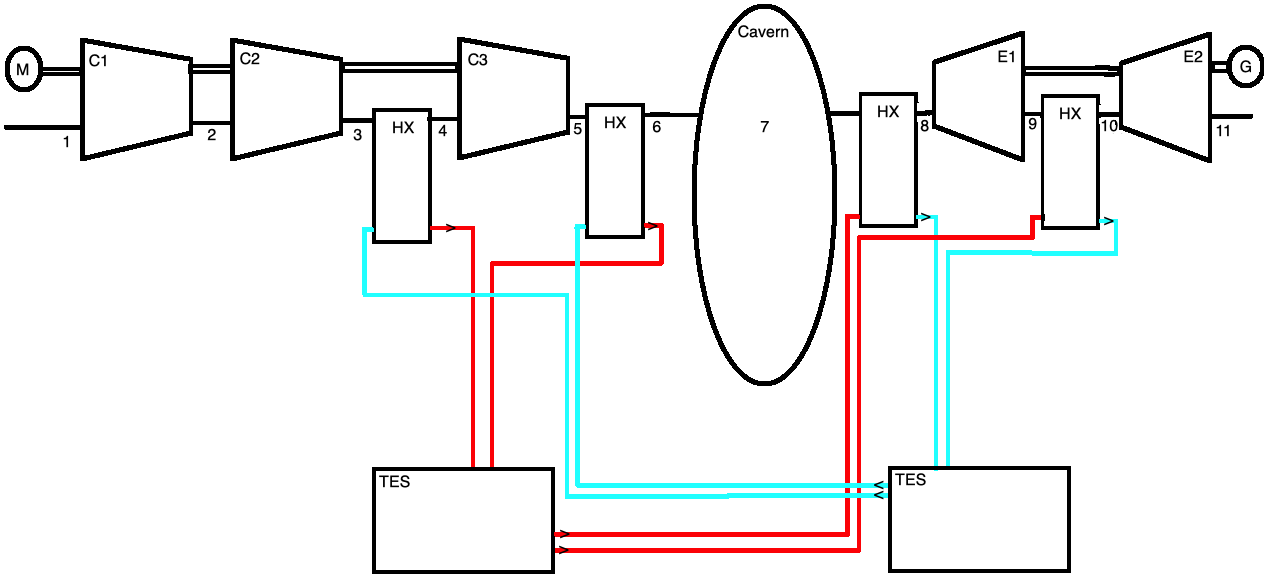

This means that p7 = p6 = p5 = p8, in this model all these pressures will be refered to as p7 <br>
In addition, the first 2 compressors have a fixed pressure ratio while the third is variable. <br>
Same is true for the expanders, the first is variable and the second is fixed.


In [2]:
#Boundary conditions

#Ambiant air
p1 = 1.03e5    #Pa        
T1 = 11+273.15 #K

#Ideal heat exchanger functionality
T4 = T1
T6 = T1

#Fixed temperatures of hot & cold TES
Twh = 95+273.15 #K
Twl = T1
eff_TES = 0.97 #Waiting for correct value

#Fixed pressures
p2 = 13*p1   #fixed ratio
p3 = 3.51*p2 #fixed ratio
p4 = p3
p9 = 30*p1   #fixed ratio
p10 = p9
p11 = p1


#Miscellaneous           
R = 8.3145      #J / mol K  
Mm = 28.97e-3   #kg/mol
Ra = R/Mm       #J/kgK
cv = 718        #J/ kg K      TBD, used???
dt =1           #s
t_rampup = 5*60 #s
Pwind = 100e6   #W
Pout = 100e6    #W

#Cavern
V = 50000    # m^3          TBD
pmax = 100e5 # Pa      
pmin = 60e5  # Pa

#Power conversion
eff_m = 0.98 #[-]
eff_g = 0.98 #[-]

#Compressor
eff_c   = 0.9 #[-]

#Turbine
eff_t   = 0.9 #[-]

#Initial pressure in cavern
p7 = pmin

#Might have to be deleted depending on the temperature calculation
gamma=1.37


In [3]:
#Functions

#Input power, including start up time compressor, without eff_m
def Pin(t):
    if t > t_rampup:
        Pin = Pwind
    else:
        Pin = Pwind*t/t_rampup
    return Pin


#Get temperature after compression including efficiency
def Tpressurize(Tin, pin, pout, eff_c):
    # eta_c = (h1s - h0)/ (h1 - h0)
    h0 = PropsSI("H", "P", pin, "T", Tin, "air")
    # s1,s = s0 (isentropic)
    s0 = PropsSI("S", "P", pin, "T", Tin, "air")
    s1s = s0
    h1s = PropsSI("H", "S", s1s, "P", pout, "air")

    h1 = h0 + 1/eff_c * (h1s - h0) 

    T1 = PropsSI("T", "H", h1, "P", pout, "air")
    return T1


#Get temperature after expansion including efficiency
def Tdepressurize(Tin, pin, pout, eff_t):
    # eta_t = (h0 - h1)/ (h0 - h1s)
    h0 = PropsSI("H", "P", pin, "T", Tin, "air")
    # s1,s = s0
    s0 = PropsSI("S", "P", pin, "T", Tin, "air")
    s1s = s0
    h1s = PropsSI("H", "S", s1s, "P", pout, "air")

    h1 = h0 - eff_t * (h0 - h1s) # if eff_t = 1 should give same result as Tpres() function

    T1 = PropsSI("T", "H", h1, "P", pout, "air")
    return T1

#Function for temperature after (de)compression
def Tcompr(pin,pout,Tin):
    Tout_s=Tin*(pout/pin)**((gamma-1)/gamma)
    Tout = Tin + (Tout_s-Tin)/eff_c
    return Tout


#Get enthalpy for known T,p
def hTp(p,T):
    return PropsSI("H","P",p,"T",T,"air")


# mass flow as a function of time
def mdot_in(t, p7):
    if p7 < pmax:
        
        #Specific work, dh3 is a function of time as p7 is a depended on time
        dh1 = hTp(p2,T2)-hTp(p1,T1)
        dh2 = hTp(p3,T3)-hTp(p2,T2) #possibly add dh1 and dh2 to cancel htp(p2,T2) to increase computation speed
        dh3 = hTp(p7,T5)-hTp(p4,T4)

        return (Pin(t)*(eff_c*eff_m))/(dh1+dh2+dh3)
    
    #If the pressure is at its max, no flow is possible
    else:
        return 0

# Outgoing massflow as a result of requested output power, time depended
def mdot_out(t,p7):
    if p7 > pmin:
        
        #Specific work where dh2 is constant and dh1 is a function of time
        dh1 = hTp(p7,T8)-hTp(p9,T9)
        dh2 = hTp(p10,T10)-hTp(p11,T11)
        
        return (Pout/eff_t/eff_g/(dh1+dh2))
    else:
        return 0
        
#Function to calculate the amount of heat per second transferred to water
def Q_HX(Tin,Tout):
    Tav = (Tin+Tout)/2
    cp = PropsSI('C','T',Tav,'P',p7,'air')
    Qdot = mdot*cp*(Tout-Tin)
    return Qdot

#Function to calculate the required flow of water
def flow_cooling_liquid(Tin,Tout):
    cp = PropsSI('C','T',(Twh+Twl)/2,'P',p1,'water')
    mflow = -Q_HX(Tin,Tout)/cp/(Twh-Twl)
    return mflow

#Function to calculate the efficiency by integrating power input and output
def efficiency():
    Ein = Pwind*t_rampup/2+Pwind*(tcharge-t_rampup)
    Eout = Pout*tdecharge
    return Eout/Ein
    


/Users/jasper/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


-3069879896950.795


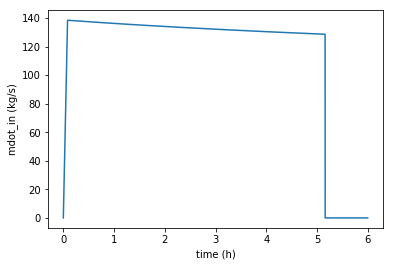

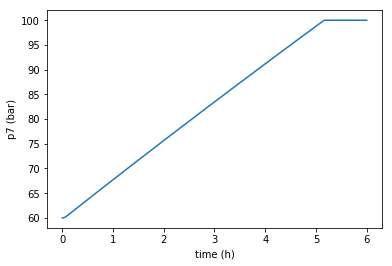

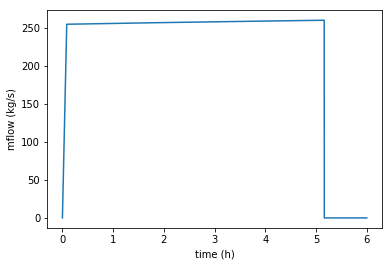

In [4]:
#Fill cavern and show various graphs 
x = []
y = []
z = []
mflow = []  
Qstored = 0
tmax=6*60*60

#Calculate Temperature after compressor stage, needed for enthalphy
#Outside of loop due to fixed p_ratio therefore fixed temperatures
T2 = Tcompr(p1,p2,T1)
T3 = Tcompr(p2,p3,T2)

for t in np.linspace(0, tmax, tmax/dt):
            
    #Calculate Temperature after compressor stage, needed for enthalphy
    T5 = Tcompr(p4,p7,T4)
    
    mdot = mdot_in(t,p7)
    p7 += mdot * dt * Ra * T6 / V
    Qstored += Q_HX(T3,T4) + Q_HX(T3,T4)
    mflow.append(flow_cooling_liquid(T3,T4)+flow_cooling_liquid(T5,T6))
    
    x.append(t/60/60)
    y.append(mdot_in(t,p7))
    z.append(p7/1e5)
    #Tout.append(Tcompr(p7))

Q_TES = abs(Qstored)*eff_TES

#Determine for how long power was provided
for t in range(t_rampup,tmax,dt):
    if y[t] != 0:
        tcharge = t

print(Qstored)   
plt.plot(x, y)
plt.xlabel("time (h)")
plt.ylabel("mdot_in (kg/s)")
plt.show()

plt.plot(x,z)
plt.xlabel("time (h)")
plt.ylabel("p7 (bar)")
plt.show()

plt.plot(x,mflow)
plt.xlabel("time (h)")
plt.ylabel("mflow (kg/s)")
plt.show()

    

552.7375363098621


/Users/jasper/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


13174


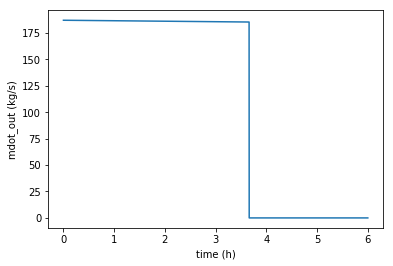

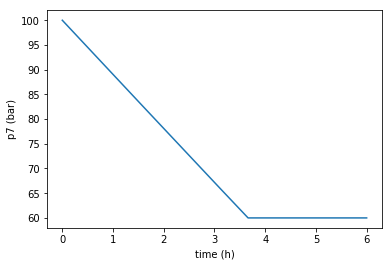

In [5]:
#Empty cavern and show various graphs 
x = []
y = []
z = []
tmax=6*60*60

#Temperature very rough approximation
cp_air=1007
Qdot = Q_TES/(0.72*tcharge)  #qdot calculation with estimated decharge time
dT=Qdot/400/cp_air
print(dT)

T8=T6 +0.1*dT           #0.1 and 0.9 weights are based on pressure ratios
T9=Tcompr(p7,p9,T8)
T10=T9 +0.9*dT
T11=Tcompr(p10,p11,T10)


for t in np.linspace(0, tmax, tmax/dt):
    
    mdot = mdot_out(t,p7)
    dp = mdot * dt * Ra * T6 / V
    p7 -= dp
    
    x.append(t/60/60)
    y.append(mdot_out(t,p7))
    z.append(p7/1e5)

    

#Determine for how long power was provided
for t in range(t_rampup,tmax,dt):
    if y[t] != 0:
        tdecharge = t
print(tdecharge)
        
plt.plot(x, y)
plt.xlabel("time (h)")
plt.ylabel("mdot_out (kg/s)")
plt.show()

plt.plot(x,z)
plt.xlabel("time (h)")
plt.ylabel("p7 (bar)")
plt.show()

#plt.plot(x,Tout)
#plt.xlabel("time (h)")
#plt.ylabel("Qdot (W)")
#plt.show()

    

In [6]:
print(efficiency())

0.714967980028221


In [10]:
print(T11)
print('This is too low for a safe outlet imo, luckily there is heat left from TES to heat until safe temperatures of >273K')

244.0502426831548
This is too low for a safe outlet imo, luckily there is heat left from TES to heat until safe temperatures of >273K
